# Sentiment analysis

Your time to shine!

We will use data from `Amazon Reviews: Unlocked Mobile Phones`, available on Kaggle platform and described as:

> PromptCloud extracted 400 thousand reviews of unlocked mobile phones sold on Amazon.com to find out insights with respect to reviews, ratings, price and their relationships. \[...\] Data was acquired in December, 2016 by the crawlers build to deliver \[their\] data extraction services.

([source](https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones/data#))

#### Load useful librairies and data

In [1]:
import pandas as pd
import numpy as np

import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [2]:
# Load data
data = pd.read_csv('./data/644_1225_compressed_Amazon_Unlocked_Mobile.csv.zip', compression="zip")

# Let's keep only a fraction of the data to speed up computations
data = data.sample(frac=0.1, random_state=10)

# Drop missing values
data.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
data = data[data['Rating'] != 3]

# Consider 4 and 5 as positive ratings (encoded as 1)
# and 1 and 2 as negative ones (encoded as 0)
data['positive_rating'] = np.where(data['Rating'] > 3, 1, 0)

In [3]:
data.sample(3)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,positive_rating
119671,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love blu products this ia my 3rd one and i a...,0.0,1
109368,BLU Dash J Unlocked Phone - Retail Packaging -...,BLU,39.99,2,Hard to use! Didn't get all the service,0.0,0
188997,"HTC DROID INCREDIBLE 2 Android Phone, Black (V...",HTC,83.98,4,Is awesome I like it alot is a really good pho...,0.0,1


## Data exploration

Before diving into the sentiment analysis, what can you tell me about the data?

In [4]:
print("Dataset contains {} instances of {} variables.".format(data.shape[0], data.shape[1]))

print(
    "It contains {} positive ratings ({:.1%} of all)".format(
        data[data.positive_rating == 1].shape[0],
        data[data.positive_rating == 1].shape[0] / data.shape[0],
    )
)

Dataset contains 30737 instances of 7 variables.
It contains 22966 positive ratings (74.7% of all)


In [5]:
print(
    "Examples of positive ratings: \n    {}\n    {}".format(
        data[data.positive_rating == 1].sample(1).Reviews.iloc[0],
        data[data.positive_rating == 1].sample(1).Reviews.iloc[0],
    )
)
print(
    "\nExamples of negative ratings: \n    {}\n    {}".format(
        data[data.positive_rating == 0].sample(1).Reviews.iloc[0],
        data[data.positive_rating == 0].sample(1).Reviews.iloc[0],
    )
)

Examples of positive ratings: 
    The service was perfect, the phone very good but my only problem is with the battery.I leave it during the night on, and in the morning is 30% less charged..I have to charge it during mid-day in order to be up & running until the night.Has anyone else faced that?
    Only thing I would not link it with my email account, all my contacts were deleted. Not the phone is was google!

Examples of negative ratings: 
    I bought the phone because it said it was unlocked and it would work worldwide, turns out that the bandwidth that the phone can detect does not support the 3g network in europe, at least in Germany where i live. I bought it expecting it to work properly and here it can only detect gsm signal. So all of the features on the phone work slower and i can't really use it like i wanted. So if you want an international phone do not buy it, if it is for the states i guess it is ok!
    I knew I was buying a used phone but I wasn't expecting there to b

#### Suggestions from workshop participants

In [18]:
data.skew()

Price               4.045777
Rating             -1.044417
Review Votes       23.270162
positive_rating    -1.137472
dtype: float64

In [19]:
data["Review Votes"].describe()

count    30737.000000
mean         1.447571
std          8.026212
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        524.000000
Name: Review Votes, dtype: float64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30737 entries, 34377 to 109303
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Product Name     30737 non-null  object 
 1   Brand Name       30737 non-null  object 
 2   Price            30737 non-null  float64
 3   Rating           30737 non-null  int64  
 4   Reviews          30737 non-null  object 
 5   Review Votes     30737 non-null  float64
 6   positive_rating  30737 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 1.9+ MB


In [25]:
import matplotlib

<AxesSubplot:>

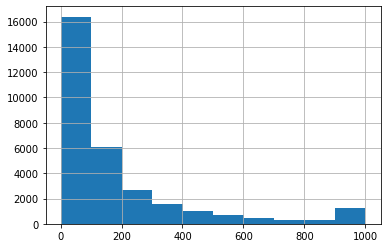

In [26]:
data['Reviews'].str.len().clip(0,1000).hist()

## Sentiment analysis

In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data['Reviews'], data['positive_rating'], random_state=0
)

Let's investigate positive / negative review classification.

#### With CountVectorizer

* What would be the AUC score (on test data) of a classifier using CountVectorizer and a Logistic Regression model (with `max_iter=1500`)?


In [7]:
# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)

# Train the model
model = LogisticRegression(max_iter=1500)
model.fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict(vect.transform(X_test))

print("AUC = {:.3f}".format(roc_auc_score(y_test, predictions)))

AUC = 0.897


* With the classifier built above, which 20 tokens are the most associated with negative reviews?

In [8]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 20 smallest coefficients
print("Smallest Coefs:\n{}\n".format(feature_names[sorted_coef_index[:20]]))

Smallest Coefs:
['worst' 'terrible' 'slow' 'junk' 'poor' 'sucks' 'horrible' 'useless'
 'waste' 'disappointed' 'broke' 'broken' 'sucked' 'defective' 'garbage'
 'wasn' 'freezes' 'wouldn' 'died' 'doesn']



* With the classifier built above, which 20 tokens are the most associated with positive reviews?

In [9]:
# Find the 20 largest coefficients
print("Largest Coefs: \n{}".format(feature_names[sorted_coef_index[:-21:-1]]))

Largest Coefs: 
['excelent' 'excelente' 'excellent' 'perfectly' 'love' 'perfect' 'exactly'
 'great' 'best' 'awesome' 'loves' 'amazing' 'wonderful' 'fantastic' 'nice'
 'exelente' 'good' 'bueno' 'loving' 'perfecto']


#### With TF-IDF Vectorizer

* What would be the AUC score (on test data) of a classifier using TfidfVectorizer and a Logistic Regression model (with `max_iter=1500`)?


In [10]:
# TfidfVectorizer specifiying a minimum document frequency of 3
vect = TfidfVectorizer(min_df=3).fit(X_train)

# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)

# Train the model
model = LogisticRegression(max_iter=1500)
model.fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict(vect.transform(X_test))

print("AUC = {:.3f}".format(roc_auc_score(y_test, predictions)))

AUC = 0.890


* Which tokens have the 10 smallest and 10 largest TF-IDF coefficients?

In [11]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print("Smallest tfidf:\n{}\n".format(feature_names[sorted_tfidf_index[:10]]))
print("Largest tfidf: \n{}".format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['peppy' 'puffin' 'funddo' 'oblong' 'solute' 'benzene' 'corrosive'
 'callsaccessories' 'calories' 'stewards']

Largest tfidf: 
['case' 'amazing' 'hi' 'too' 'top' 'tops' 'very' 'exelente' 'exelent'
 'christopher']


* With the classifier built above, which 20 tokens are the most associated with negative reviews?

In [12]:
# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 20 smallest coefficients
print("Smallest Coefs:\n{}\n".format(feature_names[sorted_coef_index[:20]]))

Smallest Coefs:
['not' 'slow' 'disappointed' 'worst' 'terrible' 'return' 'never' 'doesn'
 'horrible' 'waste' 'poor' 'months' 'broken' 'sucks' 'broke' 'wasn' 'work'
 'junk' 'off' 'useless']



* With the classifier built above, which 20 tokens are the most associated with positive reviews?

In [13]:
# Find the 20 largest coefficients
print("Largest Coefs: \n{}".format(feature_names[sorted_coef_index[:-21:-1]]))

Largest Coefs: 
['great' 'love' 'excellent' 'good' 'best' 'perfect' 'price' 'awesome'
 'far' 'perfectly' 'excelente' 'nice' 'amazing' 'easy' 'excelent'
 'exactly' 'loves' 'fast' 'happy' 'my']


## Testing our sentiment analyizer

Are our classifiers able to discriminate the following reviews:
* 'not an issue, phone is working'
* 'an issue, phone is not working'

?

In [14]:
print(model.predict(vect.transform(['not an issue, phone is working',
                                    'an issue, phone is not working'])))

[0 0]


What seems to be the issue?

## Toward improving our positive / negative review classifier

_Hint to move forward_ : Consider the option `ngram_range` of `CountVectorizer`

In [15]:
# In addition to words alone, let's consider 2-word combinations
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

model = LogisticRegression(max_iter=1500)
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print("AUC = {:.3f}".format(roc_auc_score(y_test, predictions)))

AUC = 0.911


In [16]:
feature_names = np.array(vect.get_feature_names())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['no good' 'junk' 'poor' 'slow' 'worst' 'broken' 'not good' 'terrible'
 'defective' 'horrible']

Largest Coefs: 
['excellent' 'excelente' 'excelent' 'perfect' 'great' 'love' 'awesome'
 'no problems' 'good' 'best']


Is the issue now fixed?

In [17]:
print(model.predict(vect.transform(['not an issue, phone is working',
                                    'an issue, phone is not working'])))

[1 0]
